In [38]:
import numpy as np

def make_M1(n, k_energy=0.9):
    # 均匀能量矩阵（随机正交 + 递减奇异值）
    U, _ = np.linalg.qr(np.random.randn(n, n))
    vals = np.linspace(1.0, 0.01, n)
    vals /= vals.sum()
    Σ = np.diag(vals)
    return U @ Σ @ U.T

def make_M2(n, p=10):
    # 列范数长尾 在M1基础上放大前p列
    K = make_M1(n)
    K[:, :p] *= 10
    K[:p, :] *= 10
    return K

def make_M3(n):
    # 对角变幅 diag=1^2…n^2 加少量低秩噪声
    D = np.arange(1, n+1)**2
    K = np.diag(D.astype(float))
    L = np.random.randn(n, 5)
    K += 0.1 * (L @ L.T)
    return K

def make_M4(n, m=5):
    # 簇结构 
    centers = np.random.randn(m, 50)
    X = np.vstack([centers[np.random.randint(m)] + 0.05*np.random.randn(50)
                   for _ in range(n)])
    return X @ X.T

def make_M5(n, rank=10):
    # 高相干低秩 — 低秩 + 同质常数噪声
    U, _ = np.linalg.qr(np.random.randn(n, rank))
    Σ = np.diag(np.linspace(5, 1, rank))
    K = U @ Σ @ U.T
    K += 0.5 * np.ones((n, n))
    return K


In [39]:
def nystrom(K, idx, k):
    C = K[:, idx]                 # n x l
    W = K[np.ix_(idx, idx)]       # l x l
    U, S, _ = np.linalg.svd(W, full_matrices=False)
    Uk, Sk = U[:, :k], S[:k]
    Wk_inv = Uk @ np.diag(1.0/Sk) @ Uk.T
    K_hat = C @ Wk_inv @ C.T
    return K_hat

In [40]:
import numpy as np
def sample_uniform_nr(n, l, random_state=None):
    rng = np.random.default_rng(random_state)
    return rng.choice(n, size=l, replace=False)


In [41]:
import numpy as np

def sample_diagonal(K, l, replace=False, random_state=None):
    prob = np.diag(K).astype(float)
    prob /= prob.sum()
    rng = np.random.default_rng(random_state)
    return rng.choice(K.shape[0], size=l, replace=replace, p=prob)


In [42]:
def sample_colnorm(K, l, replace=False, random_state=None):
    # 按列范数 ||K[:,i]||^2 权重采样
    norms2 = np.linalg.norm(K, axis=0)**2
    prob = norms2.astype(float)
    prob /= prob.sum()
    rng = np.random.default_rng(random_state)
    return rng.choice(K.shape[0], size=l, replace=replace, p=prob)


In [43]:
import numpy as np

def sample_ICL(K, l):
    n = K.shape[0]
    perm = []
    G = np.zeros((n, 0))
    diag_r = np.diag(K).copy()
    for _ in range(l):
        j = int(np.argmax(diag_r))
        perm.append(j)
        g = (K[:, j] - G @ G[j, :].T) / np.sqrt(diag_r[j])
        G = np.hstack([G, g.reshape(-1,1)])
        diag_r -= g**2
    return perm


In [44]:
import numpy as np

def sample_SMGA(K, l, s=50, random_state=None):
    rng = np.random.default_rng(random_state)
    n = K.shape[0]
    R = K.copy()
    sel = []
    for _ in range(l):
        cand = rng.choice(n, size=min(s,n), replace=False)
        scores = np.sum(R[:, cand]**2, axis=0)
        j = cand[int(np.argmax(scores))]
        sel.append(j)
        v = R[:, j].copy()
        R -= np.outer(v, v) / (v[j] if v[j]!=0 else 1)
    return sel


In [45]:
# --- 8. K-means 聚类抽样 ---
import numpy as np

def sample_kmeans(X, l, random_state=None):
    """
    先对 X 做 KMeans，取每个簇中心最近的样本列
    X: 特征矩阵（n×d）
    """
    km = SKLearnKMeans(n_clusters=l, random_state=random_state).fit(X)
    centers = km.cluster_centers_
    idx = [int(np.argmin(np.linalg.norm(X - c, axis=1))) for c in centers]
    return idx


In [51]:
import numpy as np
import pandas as pd

pd.options.display.float_format = '{:.2f}'.format
print(df)


np.random.seed(42)
n = 500
k = 50
ls = [int(0.05*n), int(0.1*n), int(0.2*n)]
reps = 5

Ms = {
    "M1": make_M1(n),
    "M2": make_M2(n),
    "M3": make_M3(n),
    "M4": make_M4(n),
    "M5": make_M5(n)
}

methods = {
    "Uniform_NR": lambda K, l: sample_uniform_nr(K.shape[0], l, random_state=42),
    "Diagonal":   lambda K, l: sample_diagonal(K, l, replace=False, random_state=42),
    "ColNorm":    lambda K, l: sample_colnorm(K, l, replace=False, random_state=42),
    "ICL":        lambda K, l: sample_ICL(K, l),
    "SMGA":       lambda K, l: sample_SMGA(K, l, random_state=42),
    #"KMeans":     lambda K, l: sample_kmeans(  # 对 M4 用 X→K 之前的 X
    #    np.vstack([np.random.randn(5,50)[np.random.randint(5)] + 0.05*np.random.randn(50)
    #               for _ in range(n)]),
    #    l, random_state=42
    #)
}

records = []
for name, K in Ms.items():
    U, S, Vt = np.linalg.svd(K, full_matrices=False)
    K_opt = (U[:, :k] * S[:k]) @ Vt[:k, :]
    opt_err = np.linalg.norm(K - K_opt, 'fro')
    for mname, sampler in methods.items():
        for l in ls:
            errs = []
            for _ in range(reps):
                idx = sampler(K, l)
                K_hat = nystrom(K, idx, k)
                errs.append(np.linalg.norm(K - K_hat, 'fro'))
            mean_err = np.mean(errs)
            std_err = np.std(errs)
            records.append({
                "Matrix": name,
                "Method": mname,
                "l/n": round(l/n,2),
                "RelAcc(%)": (opt_err/mean_err)*100,
                "StdErr": std_err
            })

df = pd.DataFrame(records)
print(df.pivot_table(index=["Matrix","l/n"], columns="Method", values="RelAcc(%)"))
df.to_csv("sampling_results.csv", index=False)


   Matrix      Method  l/n  RelAcc(%)  StdErr
0      M1  Uniform_NR 0.05      89.28    0.00
1      M1  Uniform_NR 0.10      93.29    0.00
2      M1  Uniform_NR 0.20      94.46    0.00
3      M1    Diagonal 0.05      89.21    0.00
4      M1    Diagonal 0.10      93.36    0.00
..    ...         ...  ...        ...     ...
70     M5         ICL 0.10       0.00    0.00
71     M5         ICL 0.20       0.00    0.00
72     M5        SMGA 0.05       0.00    0.00
73     M5        SMGA 0.10       0.00    0.00
74     M5        SMGA 0.20       0.00    0.00

[75 rows x 5 columns]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/_core/_methods.py:194: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Method       ColNorm  Diagonal    ICL   SMGA  Uniform_NR
Matrix l/n                                              
M1     0.05    89.21     89.21  89.42  89.45       89.28
       0.10    93.31     93.36  93.73  93.76       93.29
       0.20    94.40     94.47  94.72  94.79       94.46
M2     0.05    90.35     22.11  90.53  24.01        7.05
       0.10    94.44     94.46  94.85  94.77        7.20
       0.20    95.50     95.44  95.73  95.72        7.15
M3     0.05    83.57     82.08  87.37  86.91       78.86
       0.10    90.52     86.94 100.00  99.35       81.24
       0.20    96.00     93.40 100.00 100.00       85.06
M4     0.05     0.00      0.00   0.00   0.00        0.00
       0.10     0.01      0.00   0.06   0.04        0.00
       0.20     0.27      0.29   0.09   0.41        0.24
M5     0.05     0.00      0.00   0.00   0.00        0.00
       0.10     0.00      0.00   0.00   0.00        0.00
       0.20     0.00      0.00   0.00   0.00        0.00


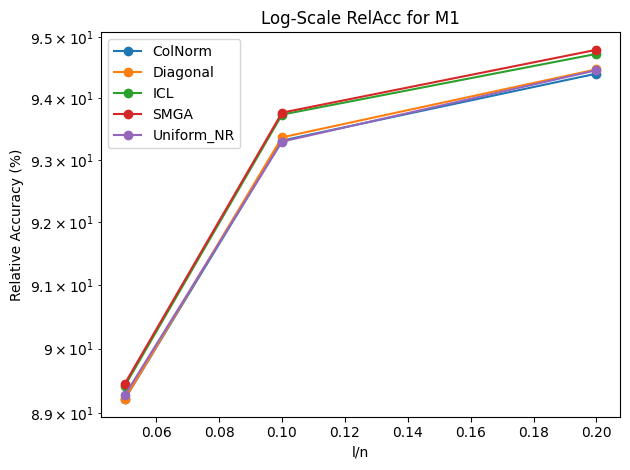

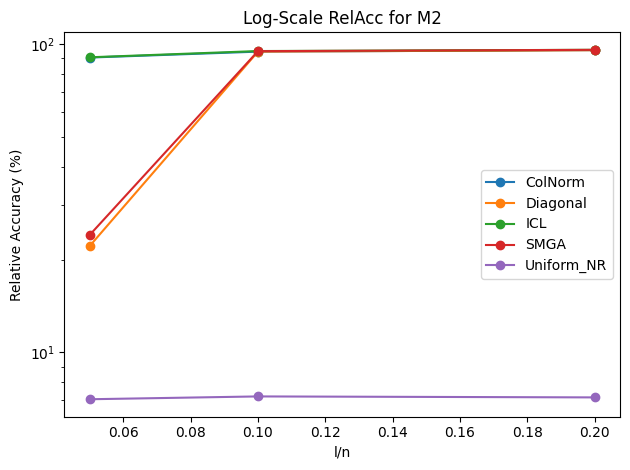

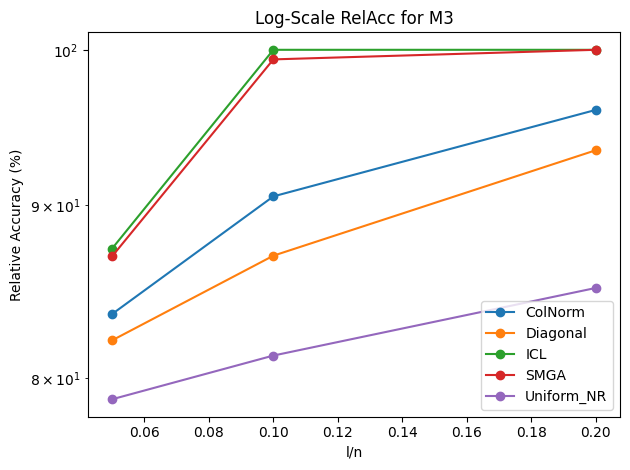

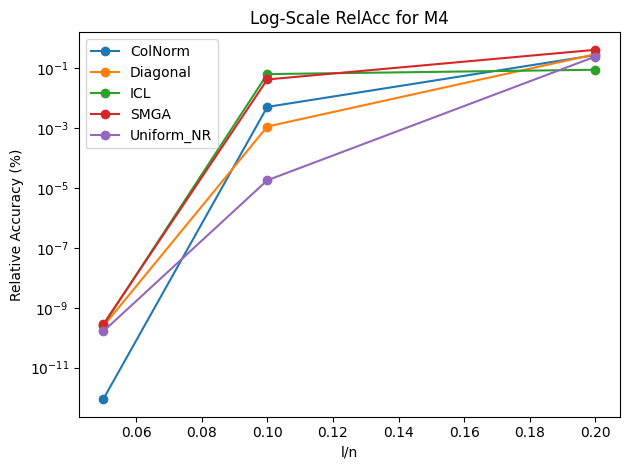

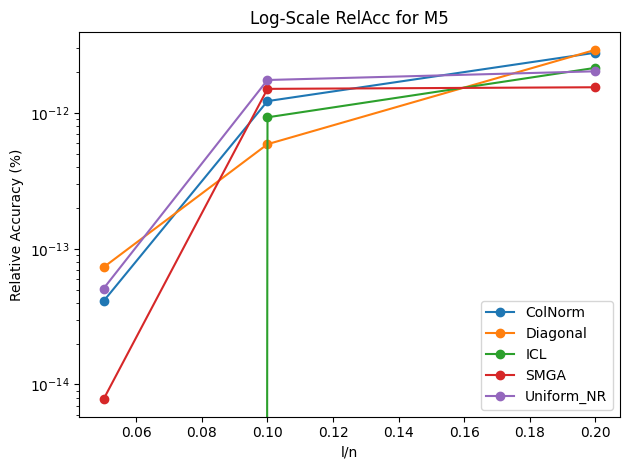

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('sampling_results.csv')
df['l/n'] = df['l/n'].astype(float)

for matrix, group in df.groupby('Matrix'):
    plt.figure()
    for method, sub in group.groupby('Method'):
        plt.plot(sub['l/n'], sub['RelAcc(%)'], marker='o', label=method)
    plt.yscale('log')
    plt.title(f'Log-Scale RelAcc for {matrix}')
    plt.xlabel('l/n')
    plt.ylabel('Relative Accuracy (%)')
    plt.legend()
    plt.tight_layout()
    plt.show()
